Demography 88<br>
Fall 2017<br>
Carl Mason (cmason@berkeley.edu)<br>

# Lab 9: Mariel Boatlift(second part): Bootstrapping the differences

In last week's lab, you mastered the CPS, the Miami labor market of the early 1980s, and the intricacies of computing weighted averages of grouped data. This week, we'll pick up where we left off and attempt to extend David Card's work in measuring the effect of the Mariel Boatlift on pre-boatlift Miamians. Our main tool for this will be the bootstrap, and our main contribution to science will be to search among carefully defined subgroups of the population, for those whose labor market experiences were negatively affected by the arrival of the Mariel Cubans.

To help us develop clearly defined subsets of the labor force, we'll start by investigating some of the variables in Merged Outgoing Rotation Groups (morg) dataset that we have not looked at yet.

After examining morg,  We'll  build a template for computing a difference in difference statistic using the wtdMean() function --which we'll use with a bootstrap simulation. 

Finally, you'll be turned loose to develop and test your own hypotheses.





In [4]:
# Run this cell to import the stuff we'll need
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

%matplotlib inline
from datascience import Table
from datascience.predicates import are
from datascience.util import *

from IPython.display import HTML, IFrame, display
datasite="http://courses.demog.berkeley.edu/mason88/data/"
quizsite="http://courses.demog.berkeley.edu/mason88/cgi-bin/quiz.py"
  
def cquiz(qno) : 
    import IPython, requests 
    try:
        sid
    except NameError: 
        print("HEY! did you enter your sid way up at the top of this notebook?")
    Linkit='{0}?qno={1}&sid={2}'.format(quizsite,qno,sid)
    #print(Linkit)
    html = requests.get(Linkit)
    #display(IFrame(Linkit, 1000, 300))
    display(IFrame(Linkit, 1000, 400))


    
######################
# Here it is ... the obvious place to put your student id
sid=""
######################
if sid == "" :
    print("HEY! didn't I tell you to put your sid in the obvious place")
 


HEY! didn't I tell you to put your sid in the obvious place


## With whom are you working on this lab?

In [6]:
cquiz('mariel1-partners')

## Read the data

In [7]:
# Read the data -- "morg" stands of "merged outgoing rotation groups" which are a subset of the data collected in 
# Current Population Survey

morg=Table.read_table(datasite+"morgClean.csv")

# and add the variable lnWage for log of hourly wage
morg=morg.with_column('lnWage',np.log(morg['Earnhr']))
# and we're going to need an indicator varialbe for Miami of course
morg.append_column('Miami',[smsa == 'Miami' for smsa in morg['SMSA']])
# changing NAs to 0 so that unemployed people enter computations as wage 0
morg.with_column('Earnhr',[ Earnhr if ~np.isnan(Earnhr) else 0 for Earnhr in morg['Earnhr']])


year,age,sex,EthRace,Educ,SMSA,class,Earnhr,Labf,Occupation,Unemp,occ70,occ80,esr,SelfEmployed,centcity,marital,classer,PrivateSector,hourslwa,Earnwt,Weight3,lnWage,Miami
1979,56,2,NonHisp:white,13,LA-LongBeach,1,0,True,Clerical,0,372,nan,1,False,2,4,1,1,40,581.165,565.41,nan,False
1979,54,1,NonHisp:white,12,LA-LongBeach,3,0,True,More Skilled Service Wrks,0,962,nan,1,False,2,4,2,0,40,585.795,592.78,nan,False
1979,23,1,NonHisp:white,13,LA-LongBeach,1,11.3776,True,Transportation Operatives,0,705,nan,1,False,2,1,1,1,16,584.448,563.823,2.43164,False
1979,21,2,NonHisp:white,12,LA-LongBeach,1,4.0017,True,Clerical,0,301,nan,1,False,2,1,1,1,40,600.214,585.407,1.38672,False
1979,26,1,NonHisp:white,12,LA-LongBeach,1,12.0619,True,Clerical,0,305,nan,1,False,2,3,1,1,40,615.096,590.453,2.49005,False
1979,27,1,NonHisp:white,12,LA-LongBeach,1,0,False,Craftsmen,nan,530,nan,4,False,2,3,1,1,nan,621.214,590.453,nan,False
1979,51,2,NonHisp:white,14,LA-LongBeach,6,0,True,Managers,0,245,nan,1,True,2,1,3,0,40,557.721,585.217,nan,False
1979,54,1,NonHisp:white,12,LA-LongBeach,6,0,True,Managers,0,245,nan,1,True,2,1,3,0,55,562.312,572.053,nan,False
1979,25,1,NonHisp:white,14,LA-LongBeach,6,0,True,Managers,0,245,nan,1,True,2,7,3,0,40,635.56,619.837,nan,False
1979,17,2,NonHisp:white,11,LA-LongBeach,1,0,False,Operatives,nan,643,nan,5,False,2,7,1,1,nan,594.488,577.88,nan,False


# The morg dataset up close

The next cell provides a list of the variables contained in morgClean.csv.  A couple of things to notice:
1. Variables whose names begin with an upper case letter are variables that your instructor created -- either according to explanations found in Professor Card's paper, or b applying common sense
2. Most of these variables are coded as integers where the integers which represent categorical information. Some sketchy documentation is available from NBER at http://www.nber.org/ftppub/cpsx/cpsx.pdf 

In [ ]:
# a list of all the variables in the dataset
list(morg)

In [ ]:
# by default .stats() does NOT do a great job with missing values  
# plain old .stats ,as in
# morg.select(['age','sex','Earnhr']).stats()
# will produce an ominous warning message because 
print("There are {0} missing values in Earnhr".format((np.sum(np.isnan(morg['Earnhr'])))))

# but .stats() is flexibile -- any function that takes an np array can be substituted for the defaults
# by simply listing them.  
#  Because it's python, we can also write our own functions to pass to the .stat() method.  For example
#  it's nice to know how many NON missing observations we have
def nonMiss(x):
    '''
    returns the number of observations which are not coded as nan
    '''
    return(np.sum(~np.isnan(x)))
morg.select(['age','sex','Earnhr']).stats((np.nanmin,np.nanmax,np.nanmean,np.nanmedian,len,nonMiss))
#NOTE the extra '()'  .stats() expects a tuple of function names, more than one function is required

## Summary statistics
For continuous or integer variables, the .stats() method is a handy way of exploring the data set
when combined with .where() and .select() one can get specific about population subgroups.


In [9]:
cquiz('mariel1-11')

## For categorical data and for breaking things up into groups.. the .pivot() method is your friend



In [11]:
## a simple .pivot() to look counts of observations by year and 'classer'
## BUT NO ... this one does not work well
##morg.pivot('year','classer').show()
## apparently, having too many nan's in a column causes problems

## this works better
morg.where(~np.isnan(morg['classer'])).pivot('EthRace','classer').show()
#  And a fancier one that finds the percentage of observed workers (unweighted) who are black
#  in the various employment classes across time

morg.with_column('black',morg['EthRace']=='NonHisp:black').where(~np.isnan(morg['classer'])).pivot('year','classer',values='black',collect=np.nanmean)

classer,Cuban,HispanNotCuban,NonHisp:black,NonHisp:other,NonHisp:white
1,2680,12238,9156,3377,40690
2,216,1043,2497,440,5360
3,313,632,474,408,4271
4,19,72,8,45,287
5,30,181,198,51,258


classer,1979,1980,1981,1982,1983,1984,1985
1,0.137525,0.13554,0.136377,0.141163,0.133327,0.129697,0.12151
2,0.257068,0.244329,0.270588,0.284075,0.263045,0.259082,0.246541
3,0.0805452,0.0956256,0.0904419,0.0769231,0.0568306,0.0536082,0.0992218
4,0.0135135,0.0246914,0,0.057971,0,0,0.0344828
5,0.231481,0.270492,0.333333,0.242718,0.322835,0.297521,0.196429


##  Hopefully, you are curious about what the "classer" variable means...

There are several places where you might find information about the variable in the CPS (the data set that we have been using). Here is convenient one : http://www.nber.org/morg/annual/desc/morg79/desc.txt -- you'll need to
use your browsers search function to navigate in it -- it first lists the variables, but deeper in file it tells what each category means.

##### The next question asks you about Less Skilled Service Workers. Your instinct should be to go to the above document and try to find a variable related to skills or occupation.  While this is excellent intuition, in this particular case it will not be rewarded because the variable Occupation, which holds the information that you are interested in was constructed by your instructor NOT by the CPS.  It follows the caption in Card's Table 1 -- and also Card's computer programs.  The variable is a cleaned and simplified version of the docc70 variable which gives broad occupational categories.
(Recall that the variables with upper case letters are constructed) 

The gist:  You'll need to use the variable "Occupation" to answer the next question.


## Another question for you
execute and click below as usual.

In [12]:
cquiz('mariel1-12')

# The wtdMean() function from last week

What we did above, of course, neglects the sample weights.  In order to publish in a serious journal,
we'll have to do a little better.  Let's pick up where we left off with the wtdMean() function.

In [14]:
## This is the same wtdMean function that we developed in the first Mariel Boatlift lab
def wtdMean(data,depvar,gvars=['Miami','year'],wvar='Earnwt'):

    """
    Exepcts:
    1) data: dataset (generally morg or morg.where(...));
    2) depvar: a dependent variable column e.g. lnWage; 
    3) gvars: a list of variables by which to group the data,
    and 
    4) wvar: a column of weights(Earnwt by default)
    returns a table with one row for each unique combination of gvars along  the corresponding
    weighted mean of depvar
    """
    # creat a list of column names of the input data that we need; we'll discard unused columns
    # note that we need to copy rather than asign here as we still need gvars
    allvars=gvars.copy()
    allvars.append(depvar)
    allvars.append(wvar)
    #get rid of columns we don't need
    dset=data.select(allvars)
    #get rid of rows that we don't want -- especially missing values
    dset=dset.where(~np.isnan(dset[wvar]))
    dset=dset.where(~np.isnan(dset[depvar]))
    # compute the numerator and denominator
    dset.append_column(depvar+'WTD',dset[depvar]*dset[wvar])
    result=dset.groups(gvars,collect=np.nansum)
    # and do the division
    result.append_column(depvar+"WTDmean",result[depvar+ 'WTD'' nansum']/result[wvar+' nansum'])
    # return the result tossing out some intermediate calcultions
    return(result.drop([depvar+" nansum",depvar+"WTD"+" nansum"]))

## Use the wtdMean function to compute a table of weighted means of earnings by Occupation and EthRace.

Recall the Occupation codes observations by broad categories of work.  We may wish to use these categories in our bootstrap statistics, so let's take a closer look but investigating the pattern of earnings across Occupation and EthRace.

In [15]:
## Let's use the wtdMean() function to further explore the data set.

## How about mean wages by EthRace and Occupation 

## we'll include only those in the labor force employed + unemployed
OccEthTab=wtdMean(morg.where('Labf',True),depvar=???,gvars=???,wvar='Earnwt')


## easier to see if we use the pivot-table the thing
OccEthTab.pivot('EthRace','Occupation',values='EarnhrWTDmean',collect=np.array)

SyntaxError: invalid syntax (<ipython-input-15-ee0904a4b71e>, line 6)

In [16]:
cquiz('mariel1-10')

# A statistic that captures the difference between wages in Miami and the control cities.

We observed in the first Mariel Boatlift lab, that there are persistent differences between wages in Miami and the control cities.  This sort of pattern is what the diff-in-diffs technique is designed to handle.  Because we have a control group of cities -- that did not experience the influx of Marileitos,  what we want to measure is the extent to which the *difference* between wages in Miami and wages in the control cities was *changed* between the time before the Marielitos arrived and a few years later.

This should remind you at least a little bit of the lab we did two weeks ago, on the trajectory of wages of immigrants vs non-immigrants at different ages. We're going to take the same computational approach in this lab as we did in that one.




## Let's discuss how to frame the problem

It will be helpful to draw a plot similar to those that we created last week


Miami,year,Earnwt nansum,EarnhrWTDmean
False,1979,4.15235e+06,7.14083
False,1980,4.23782e+06,6.86234
False,1981,4.32592e+06,6.85359
False,1982,4.49854e+06,6.8572
False,1983,4.39765e+06,6.72925
False,1984,4.61485e+06,6.73462
False,1985,2.39498e+06,6.63037
True,1979,501561,5.95146
True,1980,552789,5.61872
True,1981,605294,5.72133


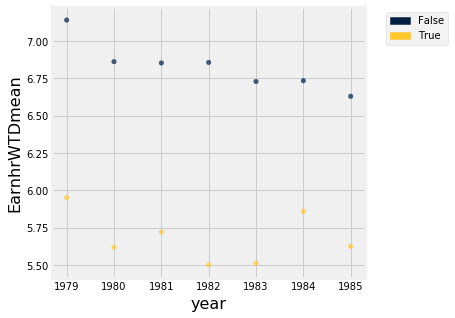

In [18]:
# Let's call this cell the "Original wageTab Cell"
# A table of weighted mean wages for Miami vs Control towns 1979-1985
## and a familliar looking plot of the two average earnings trajectories.
WageTab=wtdMean(morg.where('Labf',True),'Earnhr',gvars=['Miami','year'])
WageTab.show()
WageTab.scatter('year','EarnhrWTDmean',colors='Miami')

## Framing the problem (cont)

In the above graph, we have 8 quantities from which we'll assemble as *statistic*.  Is this sounding familiar or what!

There are many ways that we could do this. What we seek is a *difference* between Miami and the control group in 1979 and then a corresponding difference at some point *after* the boatlift.

## The quantity of interest is not one cell of this table but rather a function of a few cells.

In particular,  consider the quantity:$ (w_{C,1982}-w_{C,1979})-(w_{M,1982}-w_{M,1979})$ where $w$ are weighted mean wages, $C$ refers to combined data from all of the control cities, $M$ refers to Miami and four digit numbers like 1979 are years.

This quantity is known  as a "difference in differences" statistic--because that is what it is.  The difference between the difference  between wages in 1979 and 1982 in Miami an the Control.

#### It's a sensible quantity for us to work with if we believe that the question at hand is whether or not an influx of immigrants into Miami (but not the control cities) should have lead to decrease in wages in Miami -- relative to what they **would** have been had the influx not occurred (and thus had Miami's economy developed in the same way as the other cities.  In a sense, this "diff-in-diff" construct removes the effects of everything that's different about Miami and the control cities *but does not change over the time period in question*. 





In [ ]:
def diffStat(WageTab,EndYear=1982,depVar='EarnhrWTDmean') :
    """
    Expectes WageTab - table created by wtdMean, must include Miami and year among 'gvars' 
    depVar could be any numerical column, of WageTab, Returns a diff in diffs statistic'
    for Miami v control cities 1979- EndYear
    """
    # Using WageTab we can construct our diff-in-diff statistic like this
    wM2=(WageTab.where('Miami',True).where('year',EndYear))[depVar]
    wM1=(WageTab.where('Miami',True).where('year',1979))[depVar]
    wC2= ???
    wC1= ???
    return((wC2-wC1)-(wM2-wM1))
diffStat(WageTab,EndYear=1982)

In [23]:
cquiz('mariel1-121') 

## So we have a statistic, what could possibly make us happier?

#### How about  a *different* statistic?

Our current version of the diff-in-diffs statistic will work for our purposes, but it is NOT the *only* statistic that could do this job, and as presently implemented, it is probably not the best.

1.  Why 1982 rather than 1983 or 1984 or even 1900 -- we know that in the long run, lots of things could adjust and thereby reduce the effect, but when does the short run end?
1. Why not some other cities in the control group -- or perhaps the whole US?  Hard to say, Card chose cities that he thought were similar to Miami, Suro might argue that Miami is unique.  The best we can do here is probably to remind ourselves that the strength of this analysis rests on the magnitude of the "natural experiment": with a sudden and unexpected increase in labor supply of the the magnitude of the Mariel Boatlift, there *should* be plenty of evidence of wage impacts if indeed there were wage impacts.  
1.  As currently formulated -- with wageTab from the "Original wageTab cell", our diff-in-diff statistic looks at the mean wage of all workers in the labor force... is this wise?



In [22]:
cquiz('mariel1-122')

## Using the bootstrap with the 'diff-in-diffs' statistic -- 

Putting aside *for the moment* the question of what is the appropriate set of workers to consider in assessing the effect of immigration on wages,  let's turn to the mechanics of the bootstrap.

## Step by step template for bootstrapping the diff-in-diffs statistic



1. Construct the "original sample"  in this case it is not simply morg
1. Repeat a large number of times:
    1. draw bootstrap resample from original sample
    1. compute bootstrap statistic and store in array
1. display and interpret results

## Step 1 construct the original sample

Remember that we are only comparing Earnings in 1979 with those in 1982 the rest of the years, for now at least, we are going to ignore. Consequently, the "original sample" for this exercise is not the complete morg.

HINT: your instructor expects to find 2315 observations in Miami and 19870 in the control cities

In [ ]:
original_sample=morg.where('year',1979).append(morg.where('year',???)).where('Labf',???)
print("""
number of observations in Miami: {0}
number of observations in control towns: {1}""".format(original_sample.where('Miami',True).num_rows,
                                                      original_sample.where('Miami',False).num_rows))

## Step 2  drawing bootstrap samples

Let's set up the code to draw one set of random resamples

In [26]:
# Let's call this cell "the cell wherein we resample"
np.random.seed(13531)  # this is TEMPORARY 
print("don't forget to comment out np.random.seed when doing bootstrap for real")
bs_sample_M79=original_sample.where('Miami',True).where('year',1979).sample()
bs_sample_M82=original_sample.where('Miami',True).where('year',1982).sample()
bs_sample_C79=original_sample.where('Miami',False).where('year',1979).sample()
bs_sample_C82=original_sample.where('Miami',False).where('year',1982).sample()

don't forget to comment out np.random.seed when doing bootstrap for real


In [27]:
cquiz('mariel1-123')

## Step 3 compute bootstrap statistic from bootstrap sample

Hint: with np.random.seed(13531) set in the "Cell Wherein We Resample", the bootstrap resampled statistic should be  0.140002]



In [ ]:
bs_sample=bs_sample_M79.append(bs_sample_M82).append(bs_sample_C79).append(bs_sample_C82)
bs_WageTab=wtdMean(???,depvar='???',gvars=[???,???])
bs_statistic=diffStat(???,EndYear=???,depVar='EarnhrWTDmean')
bs_statistic

## Assemble the package

Now let's put all this code together into a single function that runs a user specified number of trials (resamples); computes the bootstrap statistic for each trial; and returns an np.array of bootstrap statistics from which we may derive profound truths.

HINT: with random.seed(13531) the function should produce the familiar value of 0.13670448 as the first element of the list of 'BSresults' returned.

## Now the science...

in the following 3 cells, we will run 100 bootstrap trials then draw some graphs that will help us interpret them.
leave the random seed set for now so we can compare results -- but don't forget about it completely.

In [ ]:
#original_sample=morg.where('year',1979).append(morg.where('year',1982)).where('Labf',True)
dINd=bootstrap_statistic(original_sample,100)

In [1]:
## there might be an easier way to plot this with datacience.Table  but I'm using
## pyplot here because I can.
def histDnD(dINd):
    """
    draws a historgram along with 95% confidence bounds. Expects an np.array -- or a column of
    a table but NOT a table
    """
    plt.figure()
    plt.hist(dINd)
    plt.title("Histogram of 95 % confidence ")
    p05=Table().with_column('dind',dINd).percentile(2.5)['dind'][0]
    p95=Table().with_column('dind',dINd).percentile(97.5)['dind'][0]
    plt.axvline(x=p05,color='red',linewidth=1)
    plt.axvline(x=p95,color='red',linewidth=1)
histDnD(dINd)    

NameError: name 'dINd' is not defined

In [ ]:
def cdfDnD(dINd) :
    """
    expects an np.array or column of a table containing bootstrap resampled statistics
    produces a CDF
    """
    dINd.sort()
    plt.plot(dINd,np.arange(len(dINd))/len(dINd),linestyle='-',linewidth=2,color='black')
    plt.title("CDF of dif in difs")
    dtab=Table().with_column('dind',dINd)
    plt.axvline(dtab.percentile(2.5)[0],linestyle=':',linewidth=2,color='blue')
    plt.axhline(.025,linestyle=':',linewidth=2,color='blue')
    plt.axvline(dtab.percentile(97.5)[0],linestyle=':',linewidth=2,color='gold')
    plt.axhline(.975,linestyle=':',linewidth=2,color='gold')

    
cdfDnD(dINd)    

In [2]:
cquiz('mariel1-124')

NameError: name 'cquiz' is not defined

In [3]:
cquiz('mariel1-125')

NameError: name 'cquiz' is not defined

# In the final segment of this lab,  *you* generate a hypothesis about the effect of the Mariel Boatlift on the Miami labor market ... and test it.

You are now an expert in the Miami labor market circa 1980 and in construction of bootstrap estimates of confidence bounds around difference in differences statistics.  Congratulations.   The final step of this process  skills that are complementary to their own.  

Well, now it's later.

The final segment of this lab comes down to defining subset X of the Miami Labor market in such a way as to be likely to find an effect -- if there is one.  In other words, devise a group of Miami workers in 1979 for whom the <i>Marielitos</i> were likely to be either substitutes OR complements. In other words a group whose wages would be most likely to either rise or fall as a result of the influx of low skilled migrants.  Then write the code necessary to bootstrap it at least 100 times.

The variables that you have to work with are:
1. Age
2. EthRace -- but note that there are too few Cubans in the other cities to make this work.
3. Education
4. Sex
5. Occupation
6. SelfEmployment, private sector, public sector

NOTE:

1. The dependent variable, presently Earnhr, is a good choice, but so night be the unemployment rate
1. There are not enough Cubans in the control cities to get an estimate so your group cannot be made up exclusively of Cubans.
1. 1979 has to be the start year,  but what you choose for your end point is up to you.

## Next week in class, you will present your results to the class.
#### No worries presentations will be brief and stress free... as long as you have completed the exercise.

In order that we have some variety in our presentations, you'll need to post your group definition to a google doc.

Hypotheses are first come first served so get to the google doc first to stake your scientific claim.  


https://docs.google.com/a/berkeley.edu/spreadsheets/d/1L905sFMexxC-iMU24-RjyFzhFaF9lR47dgsDDJambyI/edit?usp=sharing

Don't worry *too* much about the presentation -- just be prepared to answer four questions:

1. What is your subgroup of interest ?
1. What is your null hypothesis ?
1. What is the value of your statistic (on the original sample) ?
1. What is the 95 percent confidence interval of your statistic ?

In [ ]:
## devise a statistic; code and run the bootstrap with at least 100 trials

## Please evaluate this lab and remember to answer the question on the reading for next week.

In [ ]:
cquiz('marile1-eval')

In [ ]:
## The reading for next week is a critique of all that we have been doing for the last two weeks.
cquiz('borjas')